## Importaciones

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
import math

from statsmodels.tsa.seasonal import seasonal_decompose #descomposición de una serie temporal
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

from ipywidgets import interact
import plotly.express as px
import ipywidgets as widgets

from sodapy import Socrata
from pytrends.request import TrendReq
#!pip install pytrends

In [2]:
df = pd.read_csv('data/DATOS_ANUALES_H7_colectivos.csv', sep=';',encoding='latin1',decimal=",")

## Contextualizar el dataset

Se pretende estimar los días mensuales de baja por incapacidad temporal (IT) calculados en plantilla equivalente.

La intención es predecir el coste que supondría cubrir al 100% las bajas laborales cada mes hasta el final de año.

Para poder estimar el coste necesitamos dividir nuestros datos en colectivos profesionales porque cada colectivo tiene unas retribuciones particulares marcadas en la tablas retributivas del ICS.

Usamos la clasificación de categorias usadas en un proyecto anterior (PR05) y examinamos los contratos formalizados para cubrir bajas por IT:
<img src="imagenes\imagen1.png">
Vemos que hay 7 colectivos que cubren sus bajas laborales (descartamos enonces los Residentes)

Examinamos el colectivo "Otros":
<img src="imagenes\imagen2.png">
Vemos que sobretodo se cubren bajas en los subcolectivos de Mantimiento y Hoteleria. Separamos el colectivo Otros en 2 y descartamos los demás.

Antes de importar los datos hemos seleccionado sólo aquellos cuya categoria se incluye en uno de estos 8 colectivos.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   COLECTIVO                2400 non-null   object 
 1   MES                      2400 non-null   int64  
 2   AÑO                      2400 non-null   int64  
 3   Festivos_intersemanales  2400 non-null   int64  
 4   SumaDePEQ1               2400 non-null   float64
 5   SumaDePEQ_IT             2283 non-null   float64
 6   EDAD_MEDIA               2400 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 131.4+ KB


* Festivos_intersemanales: número de festivos entre semana de un determinado mes.
* SumaDePEQ1: número total de trabajadores calculado en plantilla equivalente
<img src="imagenes\imagen5.png">
* SumaDePEQ_IT: número total de bajas laborales expresado en plantilla equivalente
<img src="imagenes\imagen4.png">
* EDAD_MEDIA: Edad promedio de los trabajadores

![](img/imagen3.png)

## First Cleaning

In [4]:
#Añadimos columna en formato fecha
df['date'] = pd.to_datetime(
    dict(
        year=df['AÑO'], 
        month=df['MES'], 
        day=1
    )
)

In [5]:
#Limitamos datos a los históricos
df = df[(df['date'] < "2022-03-01")]

In [6]:
#Limitamos datos a los colectivos que cubren sus bajas IT con sustituciones
df=df[(df['COLECTIVO']!='Otros')&(df['COLECTIVO']!='Residentes/as')]

In [7]:
#Rellenamos valores nulos por 0
df=df.fillna(0)

#Renombramos columnas
df=df.rename(columns={'SumaDePEQ1':'Plantilla','SumaDePEQ_IT':'Plantilla_de_baja','EDAD_MEDIA':'Edad_promedio'})

#Ordenamos dataframe por date
df=df.sort_values(by=['COLECTIVO','date'])

In [8]:
#Repaso dataset limpiado
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1840 entries, 1854 to 1980
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   COLECTIVO                1840 non-null   object        
 1   MES                      1840 non-null   int64         
 2   AÑO                      1840 non-null   int64         
 3   Festivos_intersemanales  1840 non-null   int64         
 4   Plantilla                1840 non-null   float64       
 5   Plantilla_de_baja        1840 non-null   float64       
 6   Edad_promedio            1840 non-null   float64       
 7   date                     1840 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 129.4+ KB


In [9]:
#Calculamos la proporción de bajas en el histórico y la proporción del coste :
it_agrupadas=df.groupby(['COLECTIVO'])['Plantilla_de_baja'].sum().reset_index()
it_agrupadas['porcentaje_it']=it_agrupadas['Plantilla_de_baja']/it_agrupadas['Plantilla_de_baja'].sum()
it_agrupadas['coste_medio_mensual']=[1786.87,1700.11,1538.21,2513.58,2706.5,1539.1,1681.2,1964.21]
it_agrupadas['coste_historico_est']=it_agrupadas['Plantilla_de_baja']*it_agrupadas['coste_medio_mensual']
it_agrupadas['porcentaje_coste']=it_agrupadas['coste_historico_est']/it_agrupadas['coste_historico_est'].sum()
it_agrupadas

,COLECTIVO,Plantilla_de_baja,porcentaje_it,coste_medio_mensual,coste_historico_est,porcentaje_coste
0,Administrativos/as,3638.965938,0.110658,1786.87,6.502359e+06,0.096084
1,Auxiliar de enfermeria,9990.640873,0.303808,1700.11,1.698519e+07,0.250988
2,Celadores/as,2992.624358,0.091003,1538.21,4.603285e+06,0.068022
3,Enfermeras/os,11833.607172,0.359851,2513.58,2.974472e+07,0.439534
4,Facultativos/as,2019.798812,0.061421,2706.50,5.466585e+06,0.080779
5,Personal Hoteleria,366.723910,0.011152,1539.10,5.644248e+05,0.008340
6,Personal Mantenimiento,723.779347,0.022010,1681.20,1.216818e+06,0.017981
7,Técnicos/as especialistas,1318.578999,0.040097,1964.21,2.589966e+06,0.038272


## Primera exploración

In [10]:
df

,COLECTIVO,MES,AÑO,Festivos_intersemanales,Plantilla,Plantilla_de_baja,Edad_promedio,date
1854,Administrativos/as,1,2003,2,218.677419,17.451613,40.739937,2003-01-01
1855,Administrativos/as,2,2003,1,215.500000,18.928571,41.172224,2003-02-01
1856,Administrativos/as,3,2003,0,210.129032,14.774194,41.546919,2003-03-01
1857,Administrativos/as,4,2003,2,208.666667,15.566667,41.573832,2003-04-01
1858,Administrativos/as,5,2003,1,206.709677,15.387097,41.891405,2003-05-01
...,...,...,...,...,...,...,...,...
1774,Técnicos/as especialistas,10,2021,1,242.015806,7.402903,36.008631,2021-10-01
1775,Técnicos/as especialistas,11,2021,1,238.659000,8.887667,36.184764,2021-11-01
1776,Técnicos/as especialistas,12,2021,2,251.188710,15.032258,36.217030,2021-12-01
1979,Técnicos/as especialistas,1,2022,1,262.640000,18.152581,36.146238,2022-01-01


In [11]:
from cycler import cycler
colors= cycler(color=['#44c5c8', '#67d1d3', '#8ddcde', '#baeaea', '#ebf9f9','#434343'])
plt.rcParams['axes.prop_cycle'] =colors

<AxesSubplot:xlabel='date'>

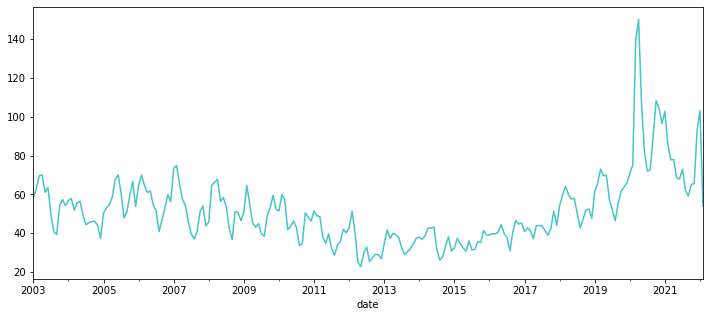

In [12]:
plt.rcParams['figure.figsize']=(12,5)
df[df['COLECTIVO']=='Enfermeras/os'].plot(x='date',y='Plantilla_de_baja',kind = 'line',legend=False)


<AxesSubplot:xlabel='date'>

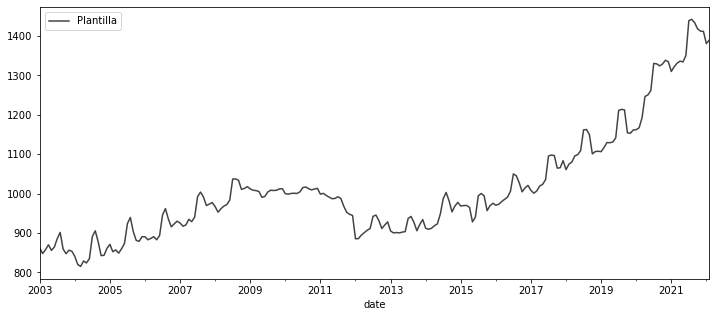

In [45]:
colors= cycler(color=['#434343'])
plt.rcParams['axes.prop_cycle'] =colors
plt.rcParams['figure.figsize']=(12,5)
df[df['COLECTIVO']=='Enfermeras/os'].plot(x='date',y='Plantilla',kind = 'line')

In [13]:
#Gráfico interactivo para comparar la evolución temporal de las diferentes variables
@interact(Colectivo=df['COLECTIVO'].unique().tolist(),Variable_Y=['Plantilla_de_baja', 'Plantilla',
       'Edad_promedio','Festivos_intersemanales'],Variable_X=['Plantilla', 'Plantilla_de_baja',
       'Edad_promedio','Festivos_intersemanales'])
def lineplot(Colectivo,Variable_Y,Variable_X):
    display(px.line(df[df['COLECTIVO']==Colectivo], x='date',y=[Variable_Y,Variable_X],title=f'{Variable_Y} y {Variable_X} de {Colectivo}'))

interactive(children=(Dropdown(description='Colectivo', options=('Administrativos/as', 'Auxiliar de enfermeria…

In [14]:
#Conclusiones
'''
Aparentemente no existe una correlación entre crecimiento de absentismo por IT y crecimiento de plantilla.
Tampoco se observa correlación clara entre crecimiento de absentismo por IT y crecimiento de edad promedio.
Se observa correlación negativa entre crecimiento de plantilla y crecimiento de edad promedio.
'''

'\nAparentemente no existe una correlación entre crecimiento de absentismo por IT y crecimiento de plantilla.\nTampoco se observa correlación clara entre crecimiento de absentismo por IT y crecimiento de edad promedio.\nSe observa correlación negativa entre crecimiento de plantilla y crecimiento de edad promedio.\n'

## Añadir nuevas variables

### Datos de incidencia COVID en Área de Salud de Badalona

In [15]:
#Accedo a la información con método Socrata y parámetros:
with open('./token.txt') as f: #Añadir txt en el repositorio con su token de socrata
    token=f.read()
with open('./password_api.txt') as f: #Añadir txt en el repositorio con su contraseña de socrata
    password_api=f.read()  

client = Socrata("analisi.transparenciacatalunya.cat",
                  token,
                  username="carlosrsir@gmail.com", #ponga aquí su username
                  password=password_api)
 

#Utilizo el método de Socrata client.get y amplio el límite a 100000 registros 
#Filtro por sector sanitario que agrupa los alrededores de Badalona
results = client.get("xuwf-dxjd",order='data DESC',limit=100000,where='sectorsanitaricodi="7867"')
#Obtengo un json llamado “results” y lo transformo en df
covid_abs_badalona=pd.json_normalize(results)
covid_abs_badalona.info()
'''Se debe transformar el campo "data" a un campo válido de fecha'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59164 entries, 0 to 59163
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   data                      59164 non-null  object
 1   regiosanitariacodi        59164 non-null  object
 2   regiosanitariadescripcio  59164 non-null  object
 3   sectorsanitaricodi        59164 non-null  object
 4   sectorsanitaridescripcio  59164 non-null  object
 5   abscodi                   59164 non-null  object
 6   absdescripcio             59164 non-null  object
 7   sexecodi                  59164 non-null  object
 8   sexedescripcio            59164 non-null  object
 9   resultatcoviddescripcio   59164 non-null  object
 10  numcasos                  59164 non-null  object
dtypes: object(11)
memory usage: 5.0+ MB


'Se debe transformar el campo "data" a un campo válido de fecha'

In [16]:
#transformo los datos que luego usaré
covid_abs_badalona['data']=pd.to_datetime(covid_abs_badalona['data'])
covid_abs_badalona['numcasos']=covid_abs_badalona['numcasos'].astype('int')
covid_abs_badalona['año']=pd.DatetimeIndex(covid_abs_badalona['data']).year
covid_abs_badalona['mes']=pd.DatetimeIndex(covid_abs_badalona['data']).month
covid_abs_badalona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59164 entries, 0 to 59163
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   data                      59164 non-null  datetime64[ns]
 1   regiosanitariacodi        59164 non-null  object        
 2   regiosanitariadescripcio  59164 non-null  object        
 3   sectorsanitaricodi        59164 non-null  object        
 4   sectorsanitaridescripcio  59164 non-null  object        
 5   abscodi                   59164 non-null  object        
 6   absdescripcio             59164 non-null  object        
 7   sexecodi                  59164 non-null  object        
 8   sexedescripcio            59164 non-null  object        
 9   resultatcoviddescripcio   59164 non-null  object        
 10  numcasos                  59164 non-null  int32         
 11  año                       59164 non-null  int64         
 12  mes               

In [17]:
#filtramos dataset con sólo los datos que nos interesa:
df_covid=covid_abs_badalona.groupby(['año','mes'])['numcasos'].sum().reset_index()
#echamos un vistazo:
df_covid.tail()

,año,mes,numcasos
20,2021,11,2707
21,2021,12,26454
22,2022,1,77920
23,2022,2,14795
24,2022,3,5448


In [18]:
# Fusionamos viejo dataset con nuevo dataset:
df=df.rename(columns={"MES": "mes", "AÑO": "año"})
df=df.merge(df_covid,left_on=['mes','año'],right_on=['mes','año'],how='left')
df=df.rename(columns={'numcasos':'casos_covid'})

In [19]:
#Rellenamos valores nulos por 0
df=df.fillna(0)
df.head()

,COLECTIVO,mes,año,Festivos_intersemanales,Plantilla,Plantilla_de_baja,Edad_promedio,date,casos_covid
0,Administrativos/as,1,2003,2,218.677419,17.451613,40.739937,2003-01-01,0.0
1,Administrativos/as,2,2003,1,215.500000,18.928571,41.172224,2003-02-01,0.0
2,Administrativos/as,3,2003,0,210.129032,14.774194,41.546919,2003-03-01,0.0
3,Administrativos/as,4,2003,2,208.666667,15.566667,41.573832,2003-04-01,0.0
4,Administrativos/as,5,2003,1,206.709677,15.387097,41.891405,2003-05-01,0.0


### Datos GoogleTrends

In [20]:
pytrend = TrendReq()

In [21]:
#provide your search terms
kw_list=['gripe sintomas','gripe','grip','sintomas gripe']
#kw_list=['Gripe','Grip','Síntomas Gripe','Baja médica','Baixa laboral']
#search interest per region
trend=pytrend.get_historical_interest(kw_list,year_start=2004, month_start=1,day_start=1,year_end=2022, month_end=2,day_end=28, geo='ES-CT',frequency='daily', sleep=0)
trend=trend.reset_index()
trend['año']=pd.DatetimeIndex(trend['date']).year
trend['mes']=pd.DatetimeIndex(trend['date']).month

#Ahora haríamos un groupby para sacar las medias del mes y sumariamos los valores medios mensuales de los 5 términos de busqueda

The request failed: Google returned a response with code 500.


In [22]:
trend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6409 entries, 0 to 6408
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            6409 non-null   datetime64[ns]
 1   gripe sintomas  6409 non-null   int32         
 2   gripe           6409 non-null   int32         
 3   grip            6409 non-null   int32         
 4   sintomas gripe  6409 non-null   int32         
 5   isPartial       6409 non-null   bool          
 6   año             6409 non-null   int64         
 7   mes             6409 non-null   int64         
dtypes: bool(1), datetime64[ns](1), int32(4), int64(2)
memory usage: 256.7 KB


'Se observa que desde octubre de 2005 los datos cambian. Podemos hacer una interpolación de los datos de 2003, 2004 y 2005'

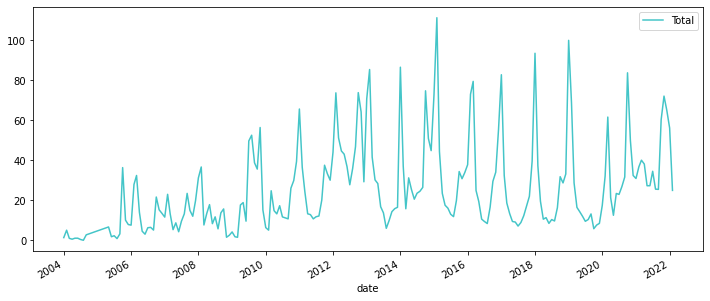

In [23]:
df_googletrends=trend.groupby(['año','mes'])[kw_list].mean().reset_index()
#df_googletrends=trend.groupby(['año','mes'])['Gripe','Grip','Baja laboral','Baja médica','Baixa laboral'].mean().reset_index()
df_googletrends['Total']=df_googletrends.drop(['año','mes'],axis=1).sum(axis=1)
df_googletrends['date']=pd.to_datetime(dict(year=df_googletrends['año'],month=df_googletrends['mes'],day=1))
#df_googletrends
plt.rcParams['figure.figsize']=(12,5)
df_googletrends.plot(x ='date', y='Total', kind = 'line')

'''Se observa que desde octubre de 2005 los datos cambian. Podemos hacer una interpolación de los datos de 2003, 2004 y 2005'''

In [24]:
df_googletrends=df_googletrends[df_googletrends['date']>'2005-09-01']

<ipython-input-25-0fc7b7b83a16>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='date'>

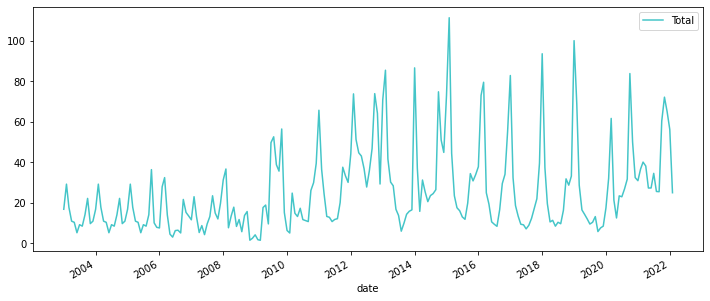

In [25]:
#interpolamos datos 2003,2004 y 2005 a partir de periodo 2006-2008
#2005
datos_interpolados=df_googletrends[(df_googletrends['año']>2005)&(df_googletrends['año']<2009)].groupby('mes')['Total'].mean().to_frame().reset_index()
datos_interpolados_2005=datos_interpolados[datos_interpolados['mes']<10]
datos_interpolados_2005['año']=2005
df_googletrends=pd.concat([df_googletrends,datos_interpolados_2005],axis=0)
#df_googletrends.merge(datos_interpolados_2005,left_on=['mes','año','Total'],right_on=['mes','año','Total'],how='left')
#2004
datos_interpolados=df_googletrends[(df_googletrends['año']>2004)&(df_googletrends['año']<2009)].groupby('mes')['Total'].mean().to_frame().reset_index()
datos_interpolados_2004=datos_interpolados
datos_interpolados_2004['año']=2004
df_googletrends=pd.concat([df_googletrends,datos_interpolados_2004],axis=0)
#2003
datos_interpolados=df_googletrends[(df_googletrends['año']>2003)&(df_googletrends['año']<2009)].groupby('mes')['Total'].mean().to_frame().reset_index()
datos_interpolados_2003=datos_interpolados
datos_interpolados_2003['año']=2003
df_googletrends=pd.concat([df_googletrends,datos_interpolados_2003],axis=0)
df_googletrends['date']=pd.to_datetime(dict(year=df_googletrends['año'],month=df_googletrends['mes'],day=1))
df_googletrends.plot(x ='date', y='Total', kind = 'line')

In [26]:
# Fusionamos viejo dataset con nuevos datasets:
df_googletrends=df_googletrends[['date','Total']].rename(columns={'Total':'busquedas_google'})
df=df.merge(df_googletrends,left_on=['date'],right_on=['date'],how='left')


### Cambio normativa bajas laborales

In [27]:
#Añadimos años de cambio de normativa
df['cambio_normativa'] = np.where((df['date'] > "2012-09-01")&(df['date'] < "2018-11-01"), 1, 0)

## Segunda exploración

In [28]:
#Hacerlo interactivo
@interact(Colectivo=df['COLECTIVO'].unique().tolist())
def pairplot(Colectivo):
    display(sns.pairplot(data=df[df.COLECTIVO==Colectivo][['Plantilla','Plantilla_de_baja','Edad_promedio','Festivos_intersemanales',
                                                          'casos_covid','busquedas_google','cambio_normativa']],
             hue='cambio_normativa'))
'''Se observa correlación entre Plantilla & Plantilla de Baja y Edad & Plantilla y Plantilla de Baja
No se puede ver la correlación COVID & Plantilla de baja porque no está limitado el df a la pandemia'''

interactive(children=(Dropdown(description='Colectivo', options=('Administrativos/as', 'Auxiliar de enfermeria…

'Se observa correlación entre Plantilla & Plantilla de Baja y Edad & Plantilla y Plantilla de Baja\nNo se puede ver la correlación COVID & Plantilla de baja porque no está limitado el df a la pandemia'

### Análisis correlación de variables con variable objetivo

In [29]:
#Hacerlo interactivo por los diferentes colectivos
@interact(Colectivo=df['COLECTIVO'].unique().tolist(), método=['spearman','pearson'])
def correlacion(Colectivo,método):
    plt.rcParams['figure.figsize']=(2,5)
    correl=df[(df.COLECTIVO==Colectivo)][['Plantilla_de_baja','Plantilla','Edad_promedio','Festivos_intersemanales',
                                                          'casos_covid','busquedas_google','cambio_normativa']].corr(method=método).iloc[0,:]
    sns.heatmap(correl.to_frame(name=método),annot=True,center=0,cmap='vlag')

interactive(children=(Dropdown(description='Colectivo', options=('Administrativos/as', 'Auxiliar de enfermeria…

In [30]:
#Añadir en la exploración un filtro que me delimite el análisis a antes de la pandemia COVID
#Hacerlo interactivo por los diferentes colectivos
@interact(Colectivo=df['COLECTIVO'].unique().tolist(), método=['spearman','pearson'])
def correlacion(Colectivo,método):
    plt.rcParams['figure.figsize']=(2,5)
    correl=df[(df.COLECTIVO==Colectivo)&(df['date'] < "2020-03-01")][['Plantilla_de_baja','Plantilla','Edad_promedio','Festivos_intersemanales',
                                                          'casos_covid','busquedas_google','cambio_normativa']].corr(method=método).iloc[0,:]
    sns.heatmap(correl.to_frame(name=método),annot=True,center=0,cmap='vlag')

interactive(children=(Dropdown(description='Colectivo', options=('Administrativos/as', 'Auxiliar de enfermeria…

<AxesSubplot:>

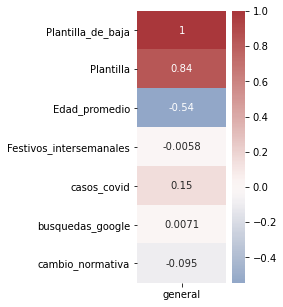

In [31]:
correl=df[['Plantilla_de_baja','Plantilla','Edad_promedio','Festivos_intersemanales',
                                                          'casos_covid','busquedas_google','cambio_normativa']].corr(method='spearman').iloc[0,:]
sns.heatmap(correl.to_frame(name='general'),annot=True,center=0,cmap='vlag')


* En general las variables 'casos COVID', 'plantilla' tienen correlación positivas respecto a la variable objetivo
* En general las variables 'Edad_promedio' & 'cambio_normativa' tienen correlación negativa respecto a la variable objetivo
* No se observa correlación apenas correlación para las variables ''busquedas_google' y 'Festivos_intersemanales'


### Análisis coliniaridad entre variables

<AxesSubplot:>

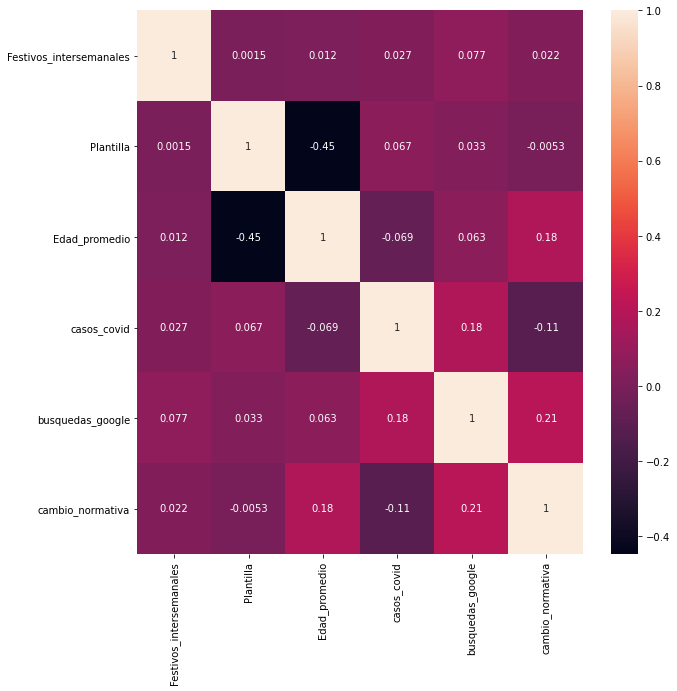

In [32]:
#Vemos que hay una correlación negativa entre edad_promedio & Plantilla (Los meses en los que no se contratan nuevos trabajadores la plantilla se envejece)
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(df.select_dtypes('number').drop(['mes','año','Plantilla_de_baja'],axis=1).corr(),annot=True)

In [33]:
#Analisis de coliniaridad con VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
X = sm.add_constant(df.select_dtypes('number').drop(['mes','año','Plantilla_de_baja'],axis=1))
pd.Series([variance_inflation_factor(X,i) for i in range (1, X.shape[1])],index=X.columns.to_list()[1:]) 

Festivos_intersemanales    1.006288
Plantilla                  1.264749
Edad_promedio              1.305491
casos_covid                1.066651
busquedas_google           1.104223
cambio_normativa           1.107722
dtype: float64

La variable no presenta mucha coliniaridad pero para eliminar confusión decidimos eliminarla del dataset

In [34]:
X = X.drop(['Edad_promedio'],axis=1)
pd.Series([variance_inflation_factor(X,i) for i in range (1, X.shape[1])],index=X.columns.to_list()[1:]) 

Festivos_intersemanales    1.006231
Plantilla                  1.004966
casos_covid                1.065554
busquedas_google           1.101177
cambio_normativa           1.072792
dtype: float64

In [35]:
df.drop('Edad_promedio',axis=1,inplace=True)

<AxesSubplot:>

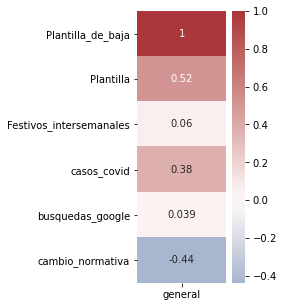

In [36]:
plt.rcParams['figure.figsize']=(2,5)
correl=df[(df.COLECTIVO=='Enfermeras/os')][['Plantilla_de_baja','Plantilla','Festivos_intersemanales',
                                                          'casos_covid','busquedas_google','cambio_normativa']].corr().iloc[0,:]
sns.heatmap(correl.to_frame(name='general'),annot=True,center=0,cmap='vlag')

## Exportaciones csv

In [38]:
#limpieza previa a exportación
df["COLECTIVO"]=df["COLECTIVO"].str.replace("Personal ","")

In [39]:
#Loop para exportar los datasets resultantes
for c in df['COLECTIVO'].unique().tolist():
    df[df['COLECTIVO']==c].reset_index().to_csv(f"output\{c[0:5]}.csv",encoding='latin-1',index=False)


In [40]:
#Exportamos también casos Covid como csv:

#Añadimos columna en formato fecha
df_covid['date'] = pd.to_datetime(
    dict(
        year=df_covid['año'], 
        month=df_covid['mes'], 
        day=1
    )
)

#Exportar a csv
df_covid.drop(['año','mes'],axis=1).to_csv("data\casos_covid.csv",encoding='latin-1',index=False)